In [1]:
import numpy as np

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import sys
import torch
import torchvision.transforms as T

from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from PIL import Image
from styleaug import StyleAugmentor
from typing import Union

In [2]:
sys.path.append('../src/')

In [3]:
from data.dataset import WheatDataset
from data.utils import basic_collate
from models.style_augment import StyleAugmentNet

In [4]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [5]:
def draw_boxes(image, bboxes):
    image = image.copy()
    for bb in bboxes:
        bb = bb[:4]
        assert len(bb) == 4
        if isinstance(bb, tuple):
            bb = tuple(map(int, bb))
        elif isinstance(bb, np.ndarray):
            bb = bb.astype(image.dtype)
        cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (1, 0, 0), 1)
    return image


def plot_images(images, targets=None):
    N = images.shape[0]
    ncols = 2
    nrows = N // ncols

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 40))
    plt.tight_layout()

    for i, img in enumerate(images):
        if targets is not None:
            img = draw_boxes(img, targets[i])
        
        row = i // ncols
        col = i % ncols
        ax[row][col].imshow(img)

In [6]:
image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

tfms = [
    A.Flip(),
    A.RandomRotate90(),
    A.Resize(640, 640, interpolation=cv2.INTER_AREA),
    A.Normalize(),
    ToTensorV2()
]
tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc'))

ds = WheatDataset(image_dir, csv_path, transforms=tfms)

Parsing bboxes...: 100%|██████████| 3373/3373 [00:22<00:00, 147.87it/s]


In [7]:
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, collate_fn=basic_collate)

In [8]:
device = torch.device('cuda:0')

In [9]:
images, targets = next(iter(dl))

In [10]:
images.shape

torch.Size([8, 3, 640, 640])

In [11]:
# style_aug = StyleAugmentor().to(device)
style_aug = StyleAugmentNet().to(device)
weights = torch.load('weights.pth')
style_aug.load_state_dict(weights)

In [12]:
alpha = torch.rand(8) * 0.33 + 0.33  # 0.33 ... 0.66

with torch.no_grad():
    styled = style_aug(images.to(device).float(), alpha=alpha)
    
styled = styled.cpu().numpy().transpose((0, 2, 3, 1))
targets = [t.cpu().numpy() for t in targets]

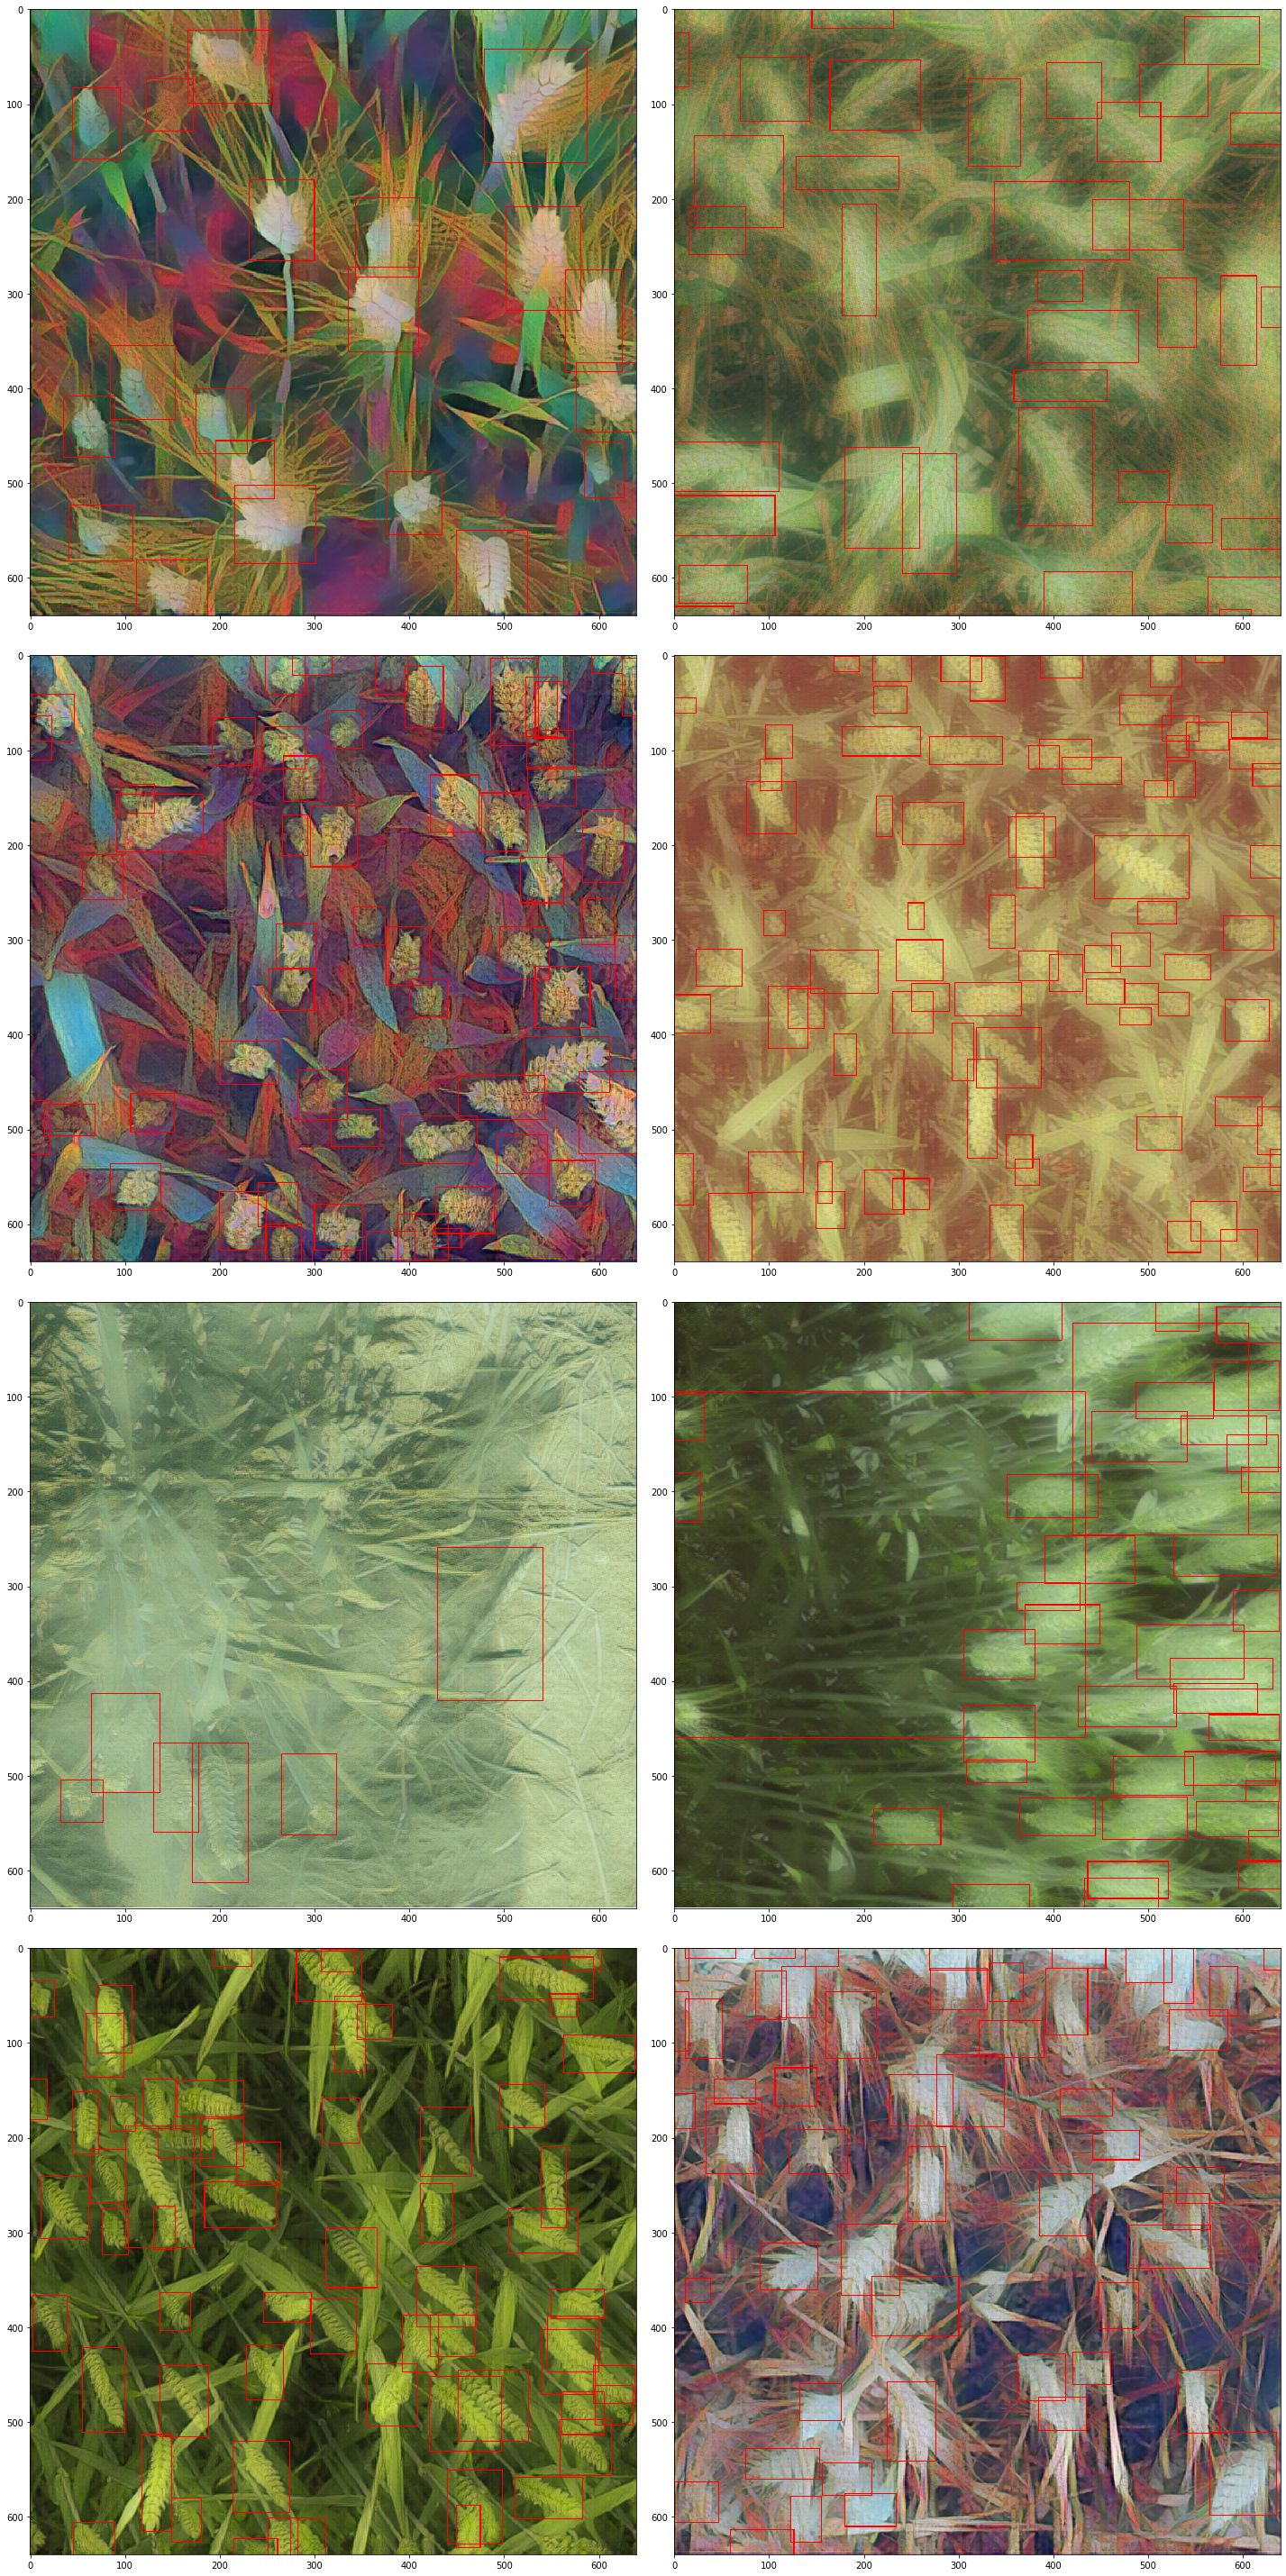

In [13]:
plot_images(styled, targets)